<a href="https://colab.research.google.com/github/ZerXXX0/CV-handwring-recognition-for-digit/blob/main/MNIST_USPS_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Used for unpickling byte stream of python objects on file system/disk
import pickle
# Used for decompressing .gzip files from file system/disk
import gzip
# Used for array operations
import numpy as np

Loading MNIST Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Opening and decompressing .gzip file
filename = '/content/drive/MyDrive/Colab Notebooks/dataset/mnist.pkl.gz'
f = gzip.open(filename, 'rb')

# Unpickling .pkl file saved as byte stream on disk to python objects
trainingData, validationData, testingData = pickle.load(f, encoding='latin1')
f.close()

# Training feature vectors and training target extracted from trainingData (target represented using one-hot format)
trainingTarget = np.array([1 if  trainingData[1][i] == t else 0  for i in range(len(trainingData[1])) for t in range(10)]).reshape(-1,10)
trainingData = trainingData[0]

# Validation feature vectors and validation target extracted from validationData
validationTarget = validationData[1]
validationData = validationData[0]

# Testing feature vectors and testing target extracted from testingData
testingTarget = testingData[1]
testingData = testingData[0]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading USPS Dataset

In [ ]:
# Used to open image in file system/disk
from PIL import Image
# Used to navigate to required directory in the file system
import os
# Used to convert image data to array
import numpy as np

In [ ]:
USPSMat  = []
USPSTar  = []
curPath  = '/content/drive/MyDrive/Colab Notebooks/dataset/USPSdata/USPSdata/Numerals'
savedImg = []


# Navigate to the 10 folders containing images for 10 labels
for j in range(0,10):
    curFolderPath = curPath + '/' + str(j)
    imgs =  os.listdir(curFolderPath)
    for img in imgs:
        curImg = curFolderPath + '/' + img
        if curImg[-3:] == 'png':

            # Open image resize it, and save image array as well as labels in 2 lists
            img = Image.open(curImg,'r')
            img = img.resize((28, 28))
            savedImg = img
            imgdata = (255-np.array(img.getdata()))/255
            USPSMat.append(imgdata)
            USPSTar.append(j)

Neural Networks

In [45]:
epoch = 10

In [46]:
import keras
from keras.datasets import mnist
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten
import time

#DNN
num_classes = len(trainingTarget[0])
DNNclassifier = Sequential()
DNNclassifier.add(Dense(units=200, activation='relu', input_shape=(len(trainingData[0]),)))
DNNclassifier.add(Dropout(0.2))
DNNclassifier.add(Dense(units=200, activation='relu'))
DNNclassifier.add(Dropout(0.2))
# DNNclassifier.add(Dense(units=200, activation='relu'))
# DNNclassifier.add(Dropout(0.2))
DNNclassifier.add(Dense(units=num_classes, activation='softmax'))
DNNclassifier.compile(optimizer='Adamax', loss='categorical_crossentropy',metrics=['accuracy'])

start_time = time.time()  # Start timing
history = DNNclassifier.fit(trainingData, trainingTarget, batch_size=128, epochs=epoch,
verbose=False,validation_data=(validationData, keras.utils.to_categorical(validationTarget, num_classes)))
end_time = time.time()  # End timing

execution_time = end_time - start_time  # Calculate elapsed time
print(f"DNN Execution Time: {execution_time:.2f} seconds")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


DNN Execution Time: 9.29 seconds


In [47]:
from sklearn.metrics import confusion_matrix

loss,valAccuracy = DNNclassifier.evaluate(validationData, keras.utils.to_categorical(validationTarget, num_classes), verbose=False)
loss,testAccuracy = DNNclassifier.evaluate(testingData, keras.utils.to_categorical(testingTarget, num_classes), verbose=False)
loss,testUSPSAccuracy = DNNclassifier.evaluate(np.array(USPSMat), keras.utils.to_categorical(USPSTar, num_classes), verbose=False)
dnnMNISTPrediction = np.argmax(DNNclassifier.predict(testingData), axis=1)
dnnUSPSPrediction = np.argmax(DNNclassifier.predict(np.array(USPSMat)), axis=1)

print ('---------------DNN----------------\n')
print('Validation accuracy    = ', valAccuracy*100)
print('MNIST Testing accuracy = ', testAccuracy*100)
print('USPS Testing accuracy  = ', testUSPSAccuracy*100,'"\n"')
print("\nMNIST Confusion Matrix: \n\n",confusion_matrix(testingTarget, dnnMNISTPrediction))
print("\nUSPS Confusion Matrix: \n\n",confusion_matrix(USPSTar, dnnUSPSPrediction))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
---------------DNN----------------

Validation accuracy    =  93.84999871253967
MNIST Testing accuracy =  93.37999820709229
USPS Testing accuracy  =  42.52861142158508 "
"

MNIST Confusion Matrix: 

 [[ 965    0    0    1    0    2    9    2    1    0]
 [   0 1119    2    2    1    1    4    2    4    0]
 [  10    2  945    9   12    1   11   18   20    4]
 [   2    1   24  919    0   24    2   19   11    8]
 [   1    1    6    0  895    0   14    2    4   59]
 [   6    1    3   20    5  814   17    5   12    9]
 [  12    3    3    0    8    7  922    1    2    0]
 [   2   10   25    3    4    0    0  953    1   30]
 [  13    5   10   11   10   15   14   15  865   16]
 [  12    6    1   10   14    4    1   14    6  941]]

USPS Confusion Matrix: 

 [[ 482    2  361   89  228  166  141  145   26  360]
 [ 180  329  303  170  216  150   37  469  125   21]
 [ 193    6 1320   88   35  148   80   65   44   20]
 

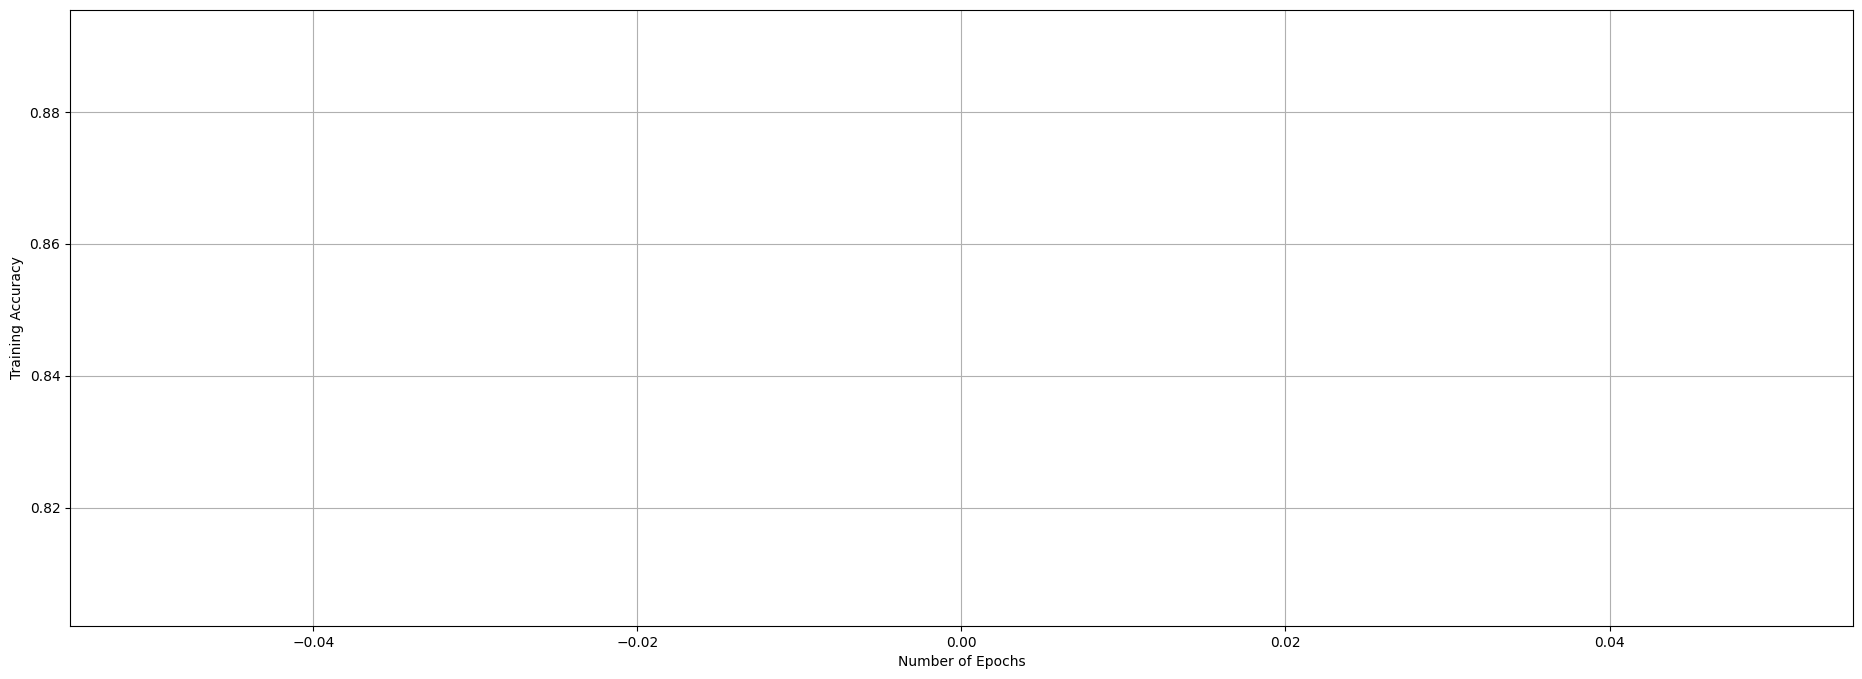

In [48]:
# The matplotlib package is used for plotting graphs
import matplotlib
import matplotlib.pyplot as plt
# Outputs training accuracy and loss against epochs
fig2, ax2=plt.subplots(figsize=(23,8))
ax2.plot(history.history['accuracy'])
ax2.set(xlabel='Number of Epochs', ylabel='Training Accuracy')
ax2.grid()
plt.show()

In [49]:
#CNN
CNNclassifier = Sequential()
CNNclassifier.add(Conv2D(20, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
CNNclassifier.add(MaxPooling2D(pool_size=(2, 2)))
CNNclassifier.add(Conv2D(20, (3, 3), activation='relu'))
CNNclassifier.add(MaxPooling2D(pool_size=(2, 2)))
CNNclassifier.add(Flatten())
CNNclassifier.add(Dense(units=200, activation='relu'))
CNNclassifier.add(Dropout(0.2))
CNNclassifier.add(Dense(units=200, activation='relu'))
CNNclassifier.add(Dropout(0.2))
CNNclassifier.add(Dense(units=num_classes, activation='softmax'))
CNNclassifier.compile(optimizer='Adamax', loss='categorical_crossentropy',metrics=['accuracy'])

start_time = time.time()  # Start timing
history = CNNclassifier.fit(trainingData.reshape(-1, 28, 28, 1), trainingTarget, batch_size=128, epochs=epoch,
verbose=True,validation_data=(validationData.reshape(-1, 28, 28, 1), keras.utils.to_categorical(validationTarget, num_classes)))
end_time = time.time()  # End timing

execution_time = end_time - start_time  # Calculate elapsed time
print(f"CNN Execution Time: {execution_time:.2f} seconds")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6974 - loss: 0.9676 - val_accuracy: 0.9612 - val_loss: 0.1369
CNN Execution Time: 6.88 seconds


In [50]:
loss,valAccuracy = CNNclassifier.evaluate(validationData.reshape(-1, 28, 28, 1), keras.utils.to_categorical(validationTarget, num_classes), verbose=False)
loss,testAccuracy = CNNclassifier.evaluate(testingData.reshape(-1, 28, 28, 1), keras.utils.to_categorical(testingTarget, num_classes), verbose=False)
loss,testUSPSAccuracy = CNNclassifier.evaluate(np.array(USPSMat).reshape(-1, 28, 28, 1), keras.utils.to_categorical(USPSTar, num_classes), verbose=False)
cnnMNISTPrediction = np.argmax(CNNclassifier.predict(testingData.reshape(-1, 28, 28, 1)), axis=1)
cnnUSPSPrediction = np.argmax(CNNclassifier.predict(np.array(USPSMat).reshape(-1, 28, 28, 1)), axis=1)

print ('---------------CNN----------------\n')
print('Validation accuracy    = ', valAccuracy*100)
print('MNIST Testing accuracy = ', testAccuracy*100)
print('USPS Testing accuracy  = ', testUSPSAccuracy*100,"\n")
print("\nMNIST Confusion Matrix: \n\n",confusion_matrix(testingTarget, cnnMNISTPrediction))
print("\nUSPS Confusion Matrix: \n\n",confusion_matrix(USPSTar, cnnUSPSPrediction))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
---------------CNN----------------

Validation accuracy    =  96.11999988555908
MNIST Testing accuracy =  95.87000012397766
USPS Testing accuracy  =  56.20921850204468 


MNIST Confusion Matrix: 

 [[ 972    0    0    0    0    0    1    1    6    0]
 [   0 1115    5    2    0    0    3    1    9    0]
 [   7    0  986    7    3    0    2   16   10    1]
 [   0    1   15  964    0    6    0   13    7    4]
 [   1    3    4    1  942    0    8    1    3   19]
 [   5    1    2   17    0  843    8    1   13    2]
 [   6    3    1    1    4    9  931    0    3    0]
 [   2    5   19    3    0    1    0  983    4   11]
 [   5    2    5    8    8    7    4   14  916    5]
 [   8    6    3    9   18    5    0   12   13  935]]

USPS Confusion Matrix: 

 [[ 517    3  254   37  439   49   77   77   56  491]
 [  92  555  134  142  350   15   37  612   49   14]
 [  92    5 1578  105   40   42   41   62   21   13]
 [ 

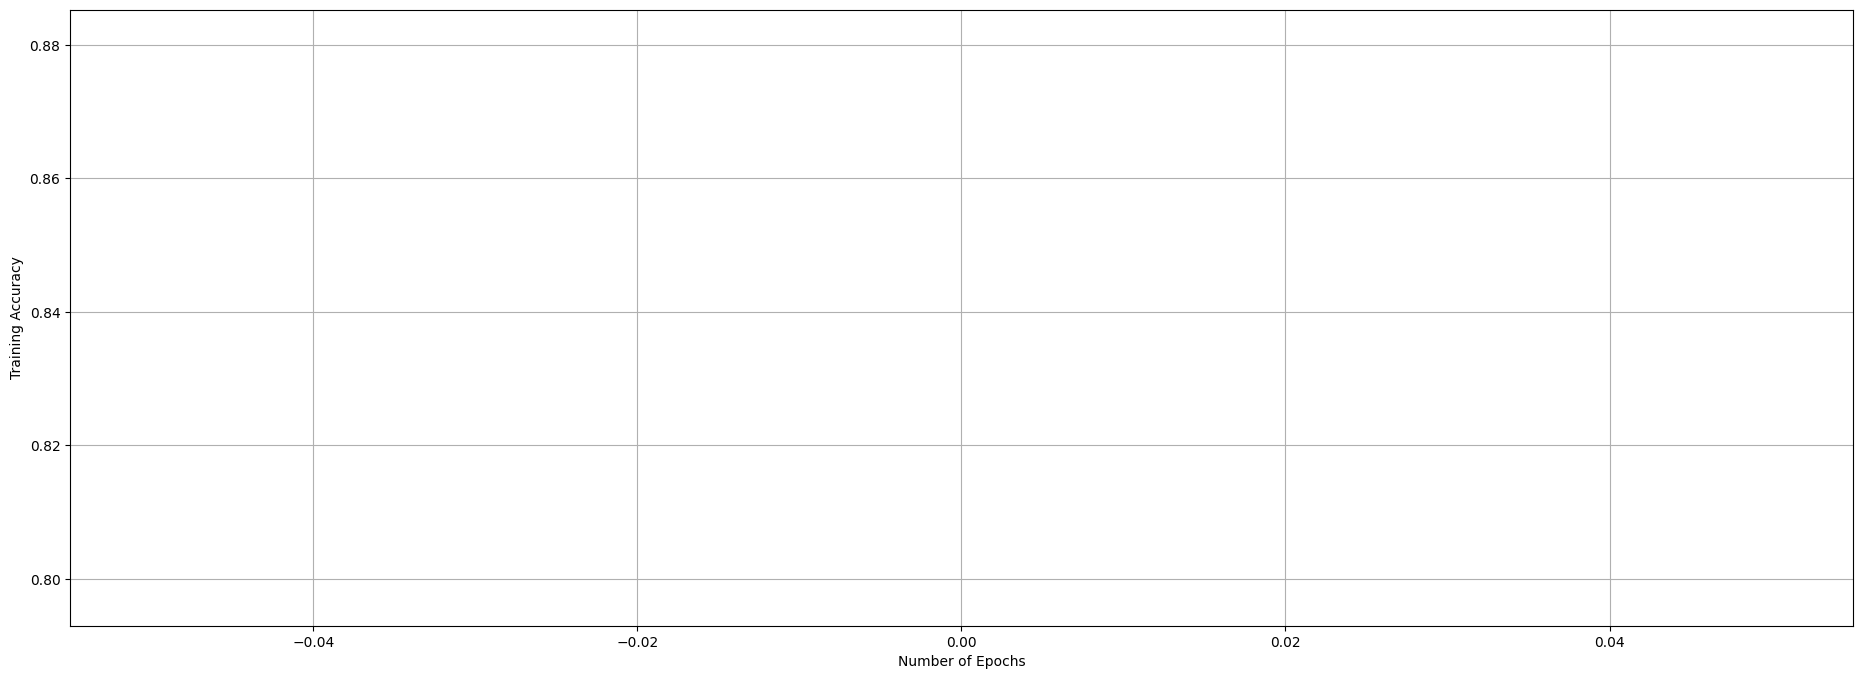

In [51]:
# The matplotlib package is used for plotting graphs
import matplotlib
import matplotlib.pyplot as plt
# Outputs training accuracy and loss against epochs
fig2, ax2=plt.subplots(figsize=(23,8))
ax2.plot(history.history['accuracy'])
ax2.set(xlabel='Number of Epochs', ylabel='Training Accuracy')
ax2.grid()
plt.show()

In [52]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import keras
import time

# RNN

num_classes = len(trainingTarget[0])  # Number of classes for classification
timesteps = 28  # Number of timesteps in the sequence
features = 28  # Number of features in each timestep

# LSTM-based model
RNNclassifier = Sequential()
RNNclassifier.add(LSTM(units=200, activation='tanh', return_sequences=True, input_shape=(timesteps, features)))
RNNclassifier.add(Dropout(0.2))
RNNclassifier.add(LSTM(units=200, activation='tanh'))
RNNclassifier.add(Dropout(0.2))
RNNclassifier.add(Dense(units=num_classes, activation='softmax'))

RNNclassifier.compile(optimizer='Adamax', loss='categorical_crossentropy', metrics=['accuracy'])

# Reshape trainingData to match the expected input shape (samples, timesteps, features)
trainingDataRNN = trainingData.reshape(-1, timesteps, features)

start_time = time.time()  # Start timing
# Training the model
history = RNNclassifier.fit(
    trainingDataRNN, # Pass the reshaped training data
    trainingTarget,
    batch_size=128,
    epochs=epoch,
    verbose=False,
    validation_data=(validationData.reshape(-1, timesteps, features), keras.utils.to_categorical(validationTarget, num_classes))
)
end_time = time.time()  # End timing

execution_time = end_time - start_time  # Calculate elapsed time
print(f"RNN Execution Time: {execution_time:.2f} seconds")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RNN Execution Time: 6.01 seconds


In [53]:
from sklearn.metrics import confusion_matrix

# Reshaping data for RNN input (samples, timesteps, features)
validationDataRNN = validationData.reshape(-1, timesteps, features)
testingDataRNN = testingData.reshape(-1, timesteps, features)
USPSDataRNN = np.array(USPSMat).reshape(-1, timesteps, features)

# Evaluate the RNN model
loss, valAccuracy = RNNclassifier.evaluate(validationDataRNN, keras.utils.to_categorical(validationTarget, num_classes), verbose=False)
loss, testAccuracy = RNNclassifier.evaluate(testingDataRNN, keras.utils.to_categorical(testingTarget, num_classes), verbose=False)
loss, testUSPSAccuracy = RNNclassifier.evaluate(USPSDataRNN, keras.utils.to_categorical(USPSTar, num_classes), verbose=False)

# Predict using the RNN model
rnnMNISTPrediction = np.argmax(RNNclassifier.predict(testingDataRNN), axis=1)
rnnUSPSPrediction = np.argmax(RNNclassifier.predict(USPSDataRNN), axis=1)

# Print results
print('---------------RNN (LSTM)----------------\n')
print('Validation accuracy    = ', valAccuracy * 100)
print('MNIST Testing accuracy = ', testAccuracy * 100)
print('USPS Testing accuracy  = ', testUSPSAccuracy * 100, "\n")
print("\nMNIST Confusion Matrix: \n\n", confusion_matrix(testingTarget, rnnMNISTPrediction))
print("\nUSPS Confusion Matrix: \n\n", confusion_matrix(USPSTar, rnnUSPSPrediction))


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
---------------RNN (LSTM)----------------

Validation accuracy    =  93.26000213623047
MNIST Testing accuracy =  93.05999875068665
USPS Testing accuracy  =  52.00555920600891 


MNIST Confusion Matrix: 

 [[ 933    0    1    0    4   22   12    1    4    3]
 [   0 1119    3    1    0    0    2    1    9    0]
 [   4    4  945   17    9    5    5   27    9    7]
 [   0    6   14  933    0    5    0   15   23   14]
 [   1    2    0    0  919    2   12    2    5   39]
 [   4    0    1    6    4  845    6    4   18    4]
 [   7    4    2    0   25   23  891    1    3    2]
 [   0    9   14    9    4    2    0  954    3   33]
 [   9    0    3   31   13   51    3    6  836   22]
 [   2    5    2    6   24    8    3   16   12  931]]

USPS Confusion Matrix: 

 [[ 954    0  252   12  288  241   28   68   11  146]
 [  34  407  371  172   11  117   20  779   73   16]
 [  68   10 1386  205   40   84   23   57   29   

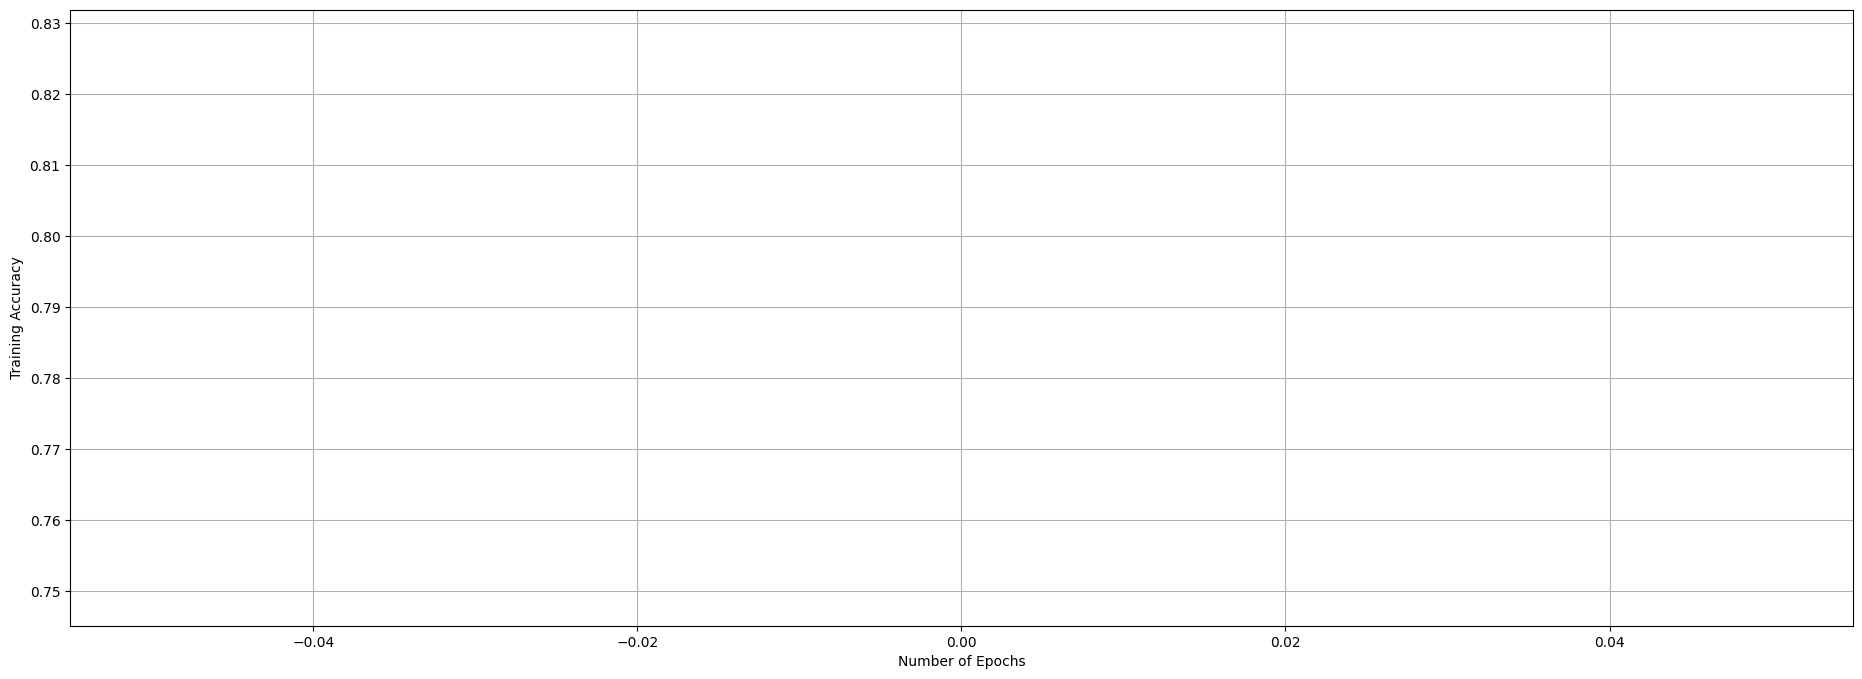

In [54]:
# The matplotlib package is used for plotting graphs
import matplotlib
import matplotlib.pyplot as plt
# Outputs training accuracy and loss against epochs
fig2, ax2=plt.subplots(figsize=(23,8))
ax2.plot(history.history['accuracy'])
ax2.set(xlabel='Number of Epochs', ylabel='Training Accuracy')
ax2.grid()
plt.show()